In [ ]:
import numpy as np
import pandas as pd
import sklearn.model_selection as skm
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from ISLP import confusion_table
from ISLP.svm import plot as plot_svm

# Data Sourcing

We will explore how predictive basic demographics, health metrics, and lifestyle are of diabetes in Western U.S. adults using data collected by the [National Health Interview Survey](https://www.cdc.gov/nchs/nhis/index.html) and accessed through [IPUMS Health Survey](https://nhis.ipums.org/nhis/). For the purposes of this assignment, we will just be using the CSV file found [here](https://github.com/mendible/5322/blob/main/Homework%202/nhis_2022.csv). The codebook in the same directory gives detailed information about the dataset.

The dataset contains 48 variables, which can be generally be organized into one of four categories: (1) survey information, (2) demographic information, (3) disease indicators, and (4) basic health metrics and habits. The survey information variables are ID numbers and sample weights from the survey methodology, which we will largely ignore. It is important to note that this dataset may be useful in predicting whether someone _has_ a disease, but it is unclear whether it could also be used to help predict whether someone will _develop_ a disease. For example, frequent consumption of sugary drinks might be correlated with developing diabetes, but here we might be more likely to see low consumption of sugary drinks correlated with diabetes because people with diabetes have to be a lot more careful about their blood sugar.


In [7]:
df = pd.read_csv("data/nhis_2022.csv")
df[:3]

,YEAR,SERIAL,STRATA,PSU,NHISHID,REGION,PERNUM,NHISPID,HHX,SAMPWEIGHT,...,TOMSAUCEMNO,SODAPNO,FRIESPNO,SPORDRMNO,FRTDRINKMNO,COFETEAMNO,POTATONO,PIZZANO,HRSLEEP,CVDSHT
0,2022,1,143,16,0002022H000001,4,1,0002022H00000110,H000001,8018.0,...,2,0,110,3,0,0,3,2,8,1
1,2022,2,106,53,0002022H000003,3,1,0002022H00000310,H000003,10117.0,...,1,0,1,0,0,1,1,1,6,2
2,2022,2,106,53,0002022H000003,3,2,0002022H00000320,H000003,7933.0,...,996,996,996,996,996,996,996,996,0,2


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35115 entries, 0 to 35114
Data columns (total 48 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   YEAR         35115 non-null  int64  
 1   SERIAL       35115 non-null  int64  
 2   STRATA       35115 non-null  int64  
 3   PSU          35115 non-null  int64  
 4   NHISHID      35115 non-null  object 
 5   REGION       35115 non-null  int64  
 6   PERNUM       35115 non-null  int64  
 7   NHISPID      35115 non-null  object 
 8   HHX          35115 non-null  object 
 9   SAMPWEIGHT   35115 non-null  float64
 10  ASTATFLG     35115 non-null  int64  
 11  CSTATFLG     35115 non-null  int64  
 12  AGE          35115 non-null  int64  
 13  SEX          35115 non-null  int64  
 14  MARSTCUR     35115 non-null  int64  
 15  EDUC         35115 non-null  int64  
 16  HOURSWRK     35115 non-null  int64  
 17  POVERTY      35115 non-null  int64  
 18  HEIGHT       35115 non-null  int64  
 19  WEIG

# Data Cleaning

As mentioned before, we are interested in predicting (Western U.S.) adult diabetes using basic demographics, health metrics, and lifestyle. In particular, we will try to predict `DIABETICEV` (whether they said they have diabetes) with the following variables:
- `AGE`: age
- `SEX`: sex
- `BMICALC`: body mass index
- `HRSLEEP`: usual number of hours of sleep per day
- `MOD10DMIN`, `VIG10DMIN`: duration of moderate/vigorous activity in minutes
- `JUICEMNO`: frequency of drinking fruit juice in past month

I would have like to include `FRUTNO`, `VEGENO`, and `SODAPNO`, but the corresponding time period variables (`FRUTTP`, `VEGETP`, and `SODAPTP`) are missing.

In [ ]:
# Subset dataset to only include the features above for (1) adults from (2) the western region
diabetes = df[(df["REGION"]==4) & (df["ASTATFLG"]==1)]["DIABETICEV AGE SEX BMICALC HRSLEEP MOD10DMIN VIG10DMIN JUICEMNO".split()]

In [128]:
"""
DIABETICEV

0: NIU (Not In Universe)
1: No or not mentioned
2: Yes or mentioned
3: Borderline
7: Unknown-refused
8: Unknown-not ascertained
9: Unknown-don't know
"""

# no "borderlines"
diabetes["DIABETICEV"].value_counts()

DIABETICEV
1    24673
2     2946
7       23
9        9
Name: count, dtype: int64

In [129]:
# only include the rows where DIABETICEV is a clear "yes" or "no"
diabetes = diabetes[diabetes["DIABETICEV"].isin([1,2])]

In [130]:
"""
AGE

085: Top code for 85 years or older (1963-1968 and 1997-forward)
090: Top code for 90 years or older (1996 only)
099: Top code for 99 years or older (1969-1995)
997: Unknown-refused
998: Unknown-not ascertained
999: Unknown-don't know
"""

diabetes[diabetes["AGE"]>=85]["AGE"].value_counts()

AGE
85     1000
997      56
999       5
Name: count, dtype: int64

In [131]:
# drop rows with unknown ages
diabetes = diabetes[diabetes["AGE"]<997]

In [132]:
"""
SEX

1: Male
2: Female
7: Unknown-refused
8: Unknown-not ascertained
9: Unknown-don't know
"""

diabetes["SEX"].value_counts()  # more women than men

SEX
2    14996
1    12559
9        2
7        1
Name: count, dtype: int64

In [133]:
# drop rows with unknown sex
diabetes = diabetes[diabetes["SEX"]<7]

In [134]:
"""
BMICALC

0.0: NIU (Not In Universe)
996.0: Not calculable
"""

# drop rows with missing BMI
diabetes = diabetes[(diabetes["BMICALC"]>0) & (diabetes["BMICALC"]<996)]

In [135]:
"""
HRSLEEP

0: NIU (Not In Universe)
25: <1
97: Unknown-refused
98: Unknown-not ascertained
99: Unknown-don't know
996.0: Not calculable
"""

# no 25's, so don't need to recode those
diabetes[diabetes["HRSLEEP"]>24]["HRSLEEP"].value_counts()

HRSLEEP
98    752
99     77
97     10
Name: count, dtype: int64

In [136]:
# drop rows with missing hours slept
diabetes = diabetes[diabetes["HRSLEEP"]<97]

In [137]:
"""
MOD10DMIN

000: Not in Universe
996: Extreme value
997: Unknown-refused
998: Unknown-not ascertained
999: Unknown-don't know
"""

# only one "extreme" value, so we can just drop it as an outlier
diabetes[(diabetes["MOD10DMIN"]==0) | (diabetes["MOD10DMIN"]>=996)]["MOD10DMIN"].value_counts()

MOD10DMIN
0      6926
999      69
996       1
997       1
Name: count, dtype: int64

In [138]:
# drop outlier and missing rows
diabetes = diabetes[(diabetes["MOD10DMIN"]>0) & (diabetes["MOD10DMIN"]<996)]

In [139]:
"""
VIG10DMIN

000: Not in Universe
996: Extreme value
997: Unknown-refused
998: Unknown-not ascertained
999: Unknown-don't know
"""

# only two "extreme" values, so we can just drop them as outliers
diabetes[(diabetes["VIG10DMIN"]==0) | (diabetes["VIG10DMIN"]>=996)]["VIG10DMIN"].value_counts()

VIG10DMIN
0      8964
999      20
996       2
997       1
Name: count, dtype: int64

In [140]:
# drop outliers and missing rows
diabetes = diabetes[(diabetes["VIG10DMIN"]>0) & (diabetes["VIG10DMIN"]<996)]

In [145]:
"""
JUICEMNO

00: Never
95: 95+
996: Not in Universe
997: Unknown-refused
998: Unknown-not ascertained
999: Unknown-don't know
"""

# 100 and 240 are weird; going to drop them
diabetes[diabetes["JUICEMNO"]>=95]["JUICEMNO"].value_counts()

JUICEMNO
998    25
999     7
997     2
240     1
100     1
Name: count, dtype: int64

In [146]:
# drop rows missing JUICEMNO (and the 100 and 240 that don't follow the code)
diabetes = diabetes[diabetes["JUICEMNO"]<=95]

In [148]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8339 entries, 7 to 35097
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DIABETICEV  8339 non-null   int64  
 1   AGE         8339 non-null   int64  
 2   SEX         8339 non-null   int64  
 3   BMICALC     8339 non-null   float64
 4   HRSLEEP     8339 non-null   int64  
 5   MOD10DMIN   8339 non-null   int64  
 6   VIG10DMIN   8339 non-null   int64  
 7   JUICEMNO    8339 non-null   int64  
dtypes: float64(1), int64(7)
memory usage: 586.3 KB


In [149]:
diabetes.describe()

,DIABETICEV,AGE,SEX,BMICALC,HRSLEEP,MOD10DMIN,VIG10DMIN,JUICEMNO
count,8339.000000,8339.000000,8339.000000,8339.000000,8339.000000,8339.000000,8339.000000,8339.000000
mean,1.045089,45.788224,1.467322,27.034033,7.079506,64.366591,56.136947,1.870128
std,0.207513,16.913669,0.498961,5.028587,1.102250,62.752605,53.569788,3.851158
min,1.000000,18.000000,1.000000,14.800000,1.000000,1.000000,1.000000,0.000000
25%,1.000000,31.000000,1.000000,23.500000,6.000000,30.000000,30.000000,0.000000
50%,1.000000,43.000000,1.000000,26.300000,7.000000,60.000000,45.000000,1.000000
75%,1.000000,60.000000,2.000000,29.850000,8.000000,60.000000,60.000000,2.000000
max,2.000000,85.000000,2.000000,51.900000,14.000000,720.000000,720.000000,60.000000


# Data Analysis

We will predict `DIABETICEV` with the other features by constructing support vector machines. In particular, we will construct three SVMs, one using a linear kernel, polynomial kernel, and radial kernel. Model performance will be assessed using test accuracy and ROC curves.

In [3]:
# predict DIABETICEV using the other features
X, y = diabetes.drop(columns=["DIABETICEV"]), diabetes["DIABETICEV"]

# Split into training and test sets (50-50 split)
X_train,X_test,y_train,y_test = skm.train_test_split(
    X,
    y,
    train_size=0.5,
    random_state=5322
)

## Linear Kernel

In [ ]:
k_fold = skm.KFold(n_splits=5, random_state=5322, shuffle=True)
grid = skm.GridSearchCV(
    estimator=SVC(kernel="linear"),
    param_grid={"C": [0.01,0.1,1,5,10]},
    refit=True,
    cv=k_fold,
    scoring="accuracy"
)
grid.fit(X_train,y_train)
grid.best_params_ 

{'C': 0.01}

In [ ]:
# It seems that all the (tested) values of C perform the same
pd.DataFrame(data={"C":[0.01,0.1,1,5,10],"Accuracy":grid.cv_results_[('mean_test_score')]})

,C,Accuracy
0,0.01,0.961408
1,0.10,0.961408
2,1.00,0.961408
3,5.00,0.961408
4,10.00,0.961408


In [80]:
# Since all the choices of C perform the same, we might as well choose the largest one (least prone to overfitting)
svm_linear = SVC(kernel="linear", C=10).fit(X_train,y_train)

In [ ]:
# training error
y_train_hat = y_train_hat = svm_linear.predict(X_train)
print(confusion_table(y_train_hat,y_train))
print(f"\nTraining Misclassification rate: {1-np.mean(y_train_hat==y_train)}\n\n")

# test error
y_test_hat = y_train_hat = svm_linear.predict(X_test)
print(confusion_table(y_test_hat,y_test))
print(f"\nTest Misclassification rate: {1-np.mean(y_test_hat==y_test)}")

Truth         1   2
Predicted          
1          1171  47
2             0   0

Training Misclassification rate: 0.03858784893267653


Truth         1   2
Predicted          
1          1175  43
2             0   0

Test Misclassification rate: 0.03530377668308704


Based on the confusion tables above, it would seem that the linear SVM just predicts the most common response (no diabetes) on the training and test set. Of course, we know that it's not that simple, and the ROC curve below suggests that the model is capturing _some_ signal (just not much).

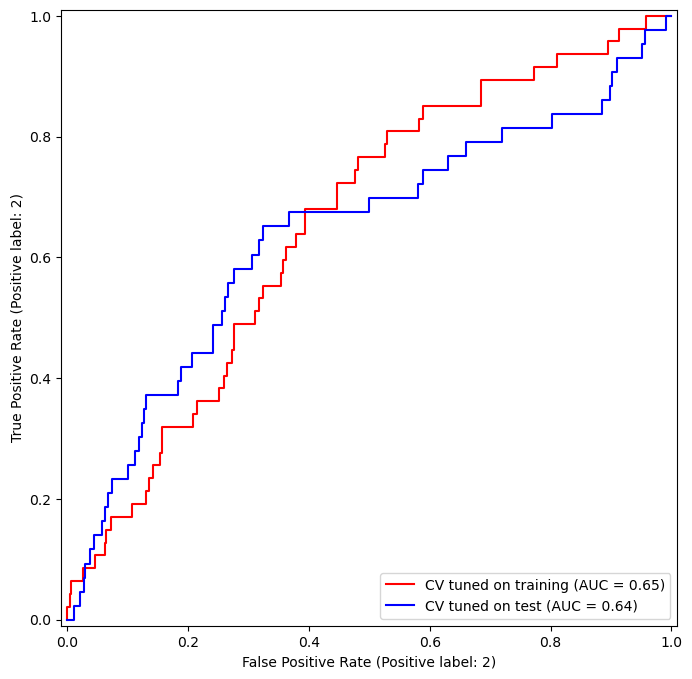

In [30]:
fig, ax = plt.subplots(figsize=(8,8))
for (X_, y_, c, name) in zip(
    (X_train, X_test),
    (y_train, y_test),
    ('r', 'b'),
    ('CV tuned on training','CV tuned on test')):
  RocCurveDisplay.from_estimator(
    svm_linear,
    X_,
    y_,
    name=name,
    ax=ax,
    color=c
  )

The ROC curve suggests that the model _is_ capturing something more than just the most common response, but not much.

## Polynomial Kernel

In [7]:
k_fold = skm.KFold(n_splits=5, random_state=5322, shuffle=True)
grid = skm.GridSearchCV(
    estimator=SVC(kernel="poly"),
    param_grid={"C": [0.1,1,10,100,1000], "degree": [2,3,4]},
    refit=True,
    cv=k_fold,
    scoring="accuracy"
)
grid.fit(X_train,y_train)
grid.best_params_ 

{'C': 0.1, 'degree': 2}

<Axes: xlabel='param_C', ylabel='param_degree'>

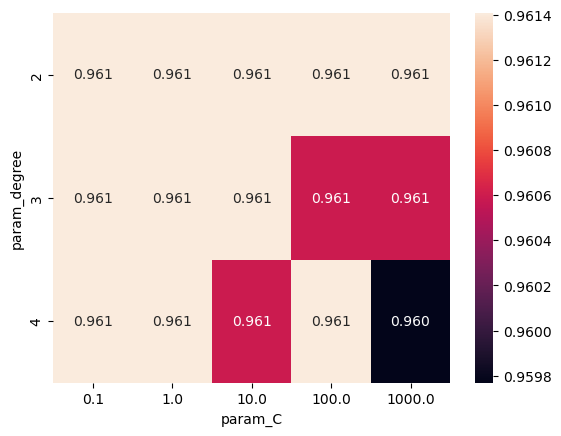

In [8]:
pivot = pd.pivot_table(
    pd.DataFrame(grid.cv_results_), 
    values="mean_test_score", 
    index="param_degree", 
    columns="param_C"
)
sns.heatmap(pivot, annot=True, fmt='.3f')

In [9]:
svm_poly = SVC(kernel="poly", C=1000, degree=2).fit(X_train,y_train)

In [12]:
# training error
y_train_hat  = svm_poly.predict(X_train)
print(confusion_table(y_train_hat,y_train))
print(f"\nTraining Misclassification rate: {1-np.mean(y_train_hat==y_train)}\n\n")

# test error
y_test_hat = svm_poly.predict(X_test)
print(confusion_table(y_test_hat,y_test))
print(f"\nTest Misclassification rate: {1-np.mean(y_test_hat==y_test)}")

Truth         1   2
Predicted          
1          1171  47
2             0   0

Training Misclassification rate: 0.03858784893267653


Truth         1   2
Predicted          
1          1175  43
2             0   0

Test Misclassification rate: 0.03530377668308704


Just like with the linear kernel, the polynomial SVM is just predicting the most common response (at least on the training and test sets), though the AUC suggests that it is doing more than that. Interestingly, the polynomial model has a _better_ training AUC and a _worse_ test AUC, which _might_ mean that the polynomial model is overfitting.

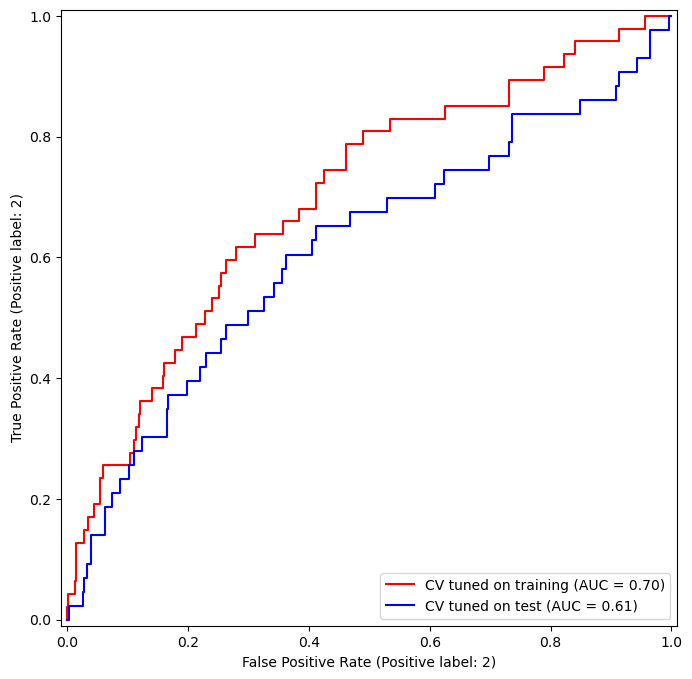

In [11]:
fig, ax = plt.subplots(figsize=(8,8))
for (X_, y_, c, name) in zip(
    (X_train, X_test),
    (y_train, y_test),
    ('r', 'b'),
    ('CV tuned on training','CV tuned on test')):
  RocCurveDisplay.from_estimator(
    svm_poly,
    X_,
    y_,
    name=name,
    ax=ax,
    color=c
  )

# Radial Kernel

In [64]:
# Radial
k_fold = skm.KFold(5, random_state=5322, shuffle=True)
grid = skm.GridSearchCV(
    estimator=SVC(kernel="rbf"),
    param_grid={"C": [0.01,0.1,1,10,1e2,1e3,1e4,1e5], "gamma": [1e-4,1e-3,0.01,0.1,1,10]},
    refit=True,
    cv=k_fold,
    scoring="accuracy"
)
grid.fit(X_train,y_train)
grid.best_params_

{'C': 0.01, 'gamma': 0.0001}

<Axes: xlabel='param_C', ylabel='param_gamma'>

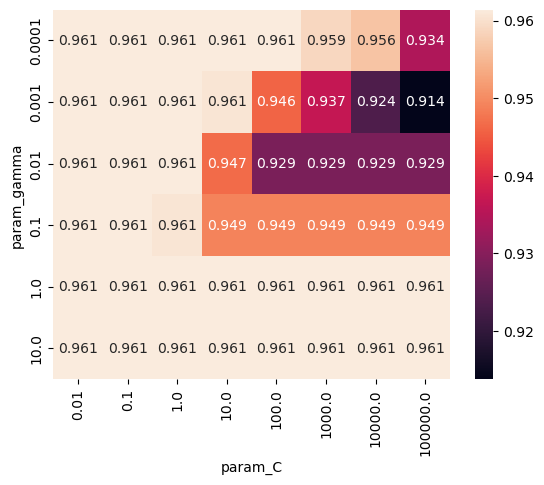

In [65]:
pivot = pd.pivot_table(
    pd.DataFrame(grid.cv_results_), 
    values="mean_test_score", 
    index="param_gamma", 
    columns="param_C"
)
sns.heatmap(pivot, annot=True, fmt='.3f')

If you actually look at the confusion tables of the worse performing settings (the darker areas), you'll see that the reason they perform worse is because they're actually trying to identify diabetes. The problem is that they overfit the training set and don't do a good job on the test set. Unfortunately, the "best" model, once again, is just predicting the most common response on the training and test sets.

In [75]:
svm_rbf = SVC(kernel="rbf", C=0.01, gamma=0.0001).fit(X_train,y_train)

In [76]:
# training error
y_train_hat  = svm_rbf.predict(X_train)
print(confusion_table(y_train_hat,y_train))
print(f"\nTraining Misclassification rate: {1-np.mean(y_train_hat==y_train)}\n\n")

# test error
y_test_hat = svm_rbf.predict(X_test)
print(confusion_table(y_test_hat,y_test))
print(f"\nTest Misclassification rate: {1-np.mean(y_test_hat==y_test)}")

Truth         1   2
Predicted          
1          1171  47
2             0   0

Training Misclassification rate: 0.03858784893267653


Truth         1   2
Predicted          
1          1175  43
2             0   0

Test Misclassification rate: 0.03530377668308704


The AUC of the ROC curve is slightly better than that of the linear and polynomial models.

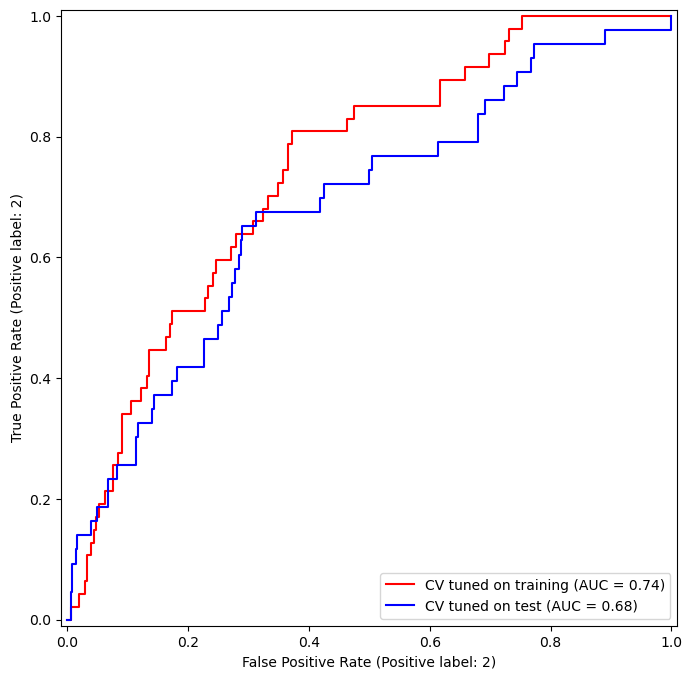

In [77]:
fig, ax = plt.subplots(figsize=(8,8))
for (X_, y_, c, name) in zip(
    (X_train, X_test),
    (y_train, y_test),
    ('r', 'b'),
    ('CV tuned on training','CV tuned on test')):
  RocCurveDisplay.from_estimator(
    svm_rbf,
    X_,
    y_,
    name=name,
    ax=ax,
    color=c
  )

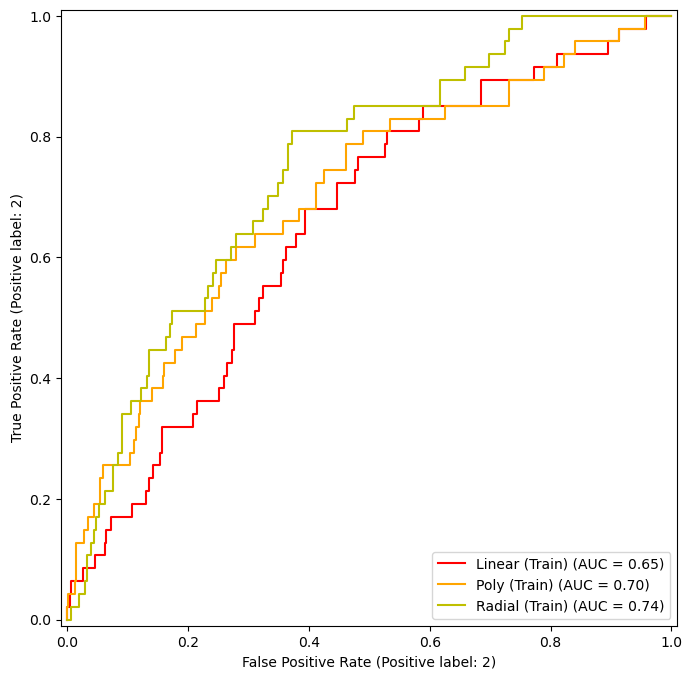

In [85]:
# Train ROC curves
fig, ax = plt.subplots(figsize=(8,8))

# Linear
RocCurveDisplay.from_estimator(
  svm_linear,
  X_train,y_train,
  name="Linear (Train)",
  ax=ax,
  color="r"
)

# Polynomial
RocCurveDisplay.from_estimator(
  svm_poly,
  X_train,y_train,
  name="Poly (Train)",
  ax=ax,
  color="orange"
)

# Radial
RocCurveDisplay.from_estimator(
  svm_rbf,
  X_train,y_train,
  name="Radial (Train)",
  ax=ax,
  color="y"
)

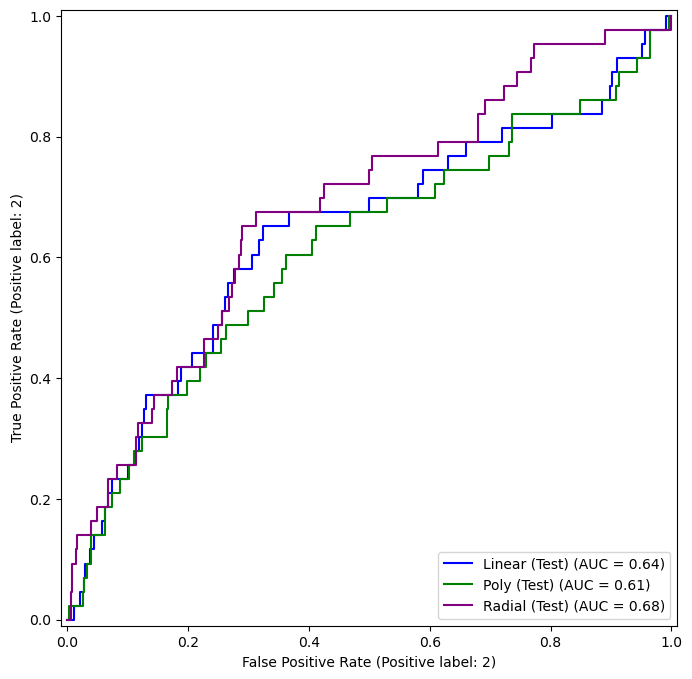

In [86]:
# Test ROC curves
fig, ax = plt.subplots(figsize=(8,8))

# Linear
RocCurveDisplay.from_estimator(
  svm_linear,
  X_test,y_test,
  name="Linear (Test)",
  ax=ax,
  color="b"
)

# Polynomial
RocCurveDisplay.from_estimator(
  svm_poly,
  X_test,y_test,
  name="Poly (Test)",
  ax=ax,
  color="g"
)

# Radial
RocCurveDisplay.from_estimator(
  svm_rbf,
  X_test,y_test,
  name="Radial (Test)",
  ax=ax,
  color="purple"
)

c:\Users\tyler\miniconda3\envs\data-science\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\tyler\miniconda3\envs\data-science\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\tyler\miniconda3\envs\data-science\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


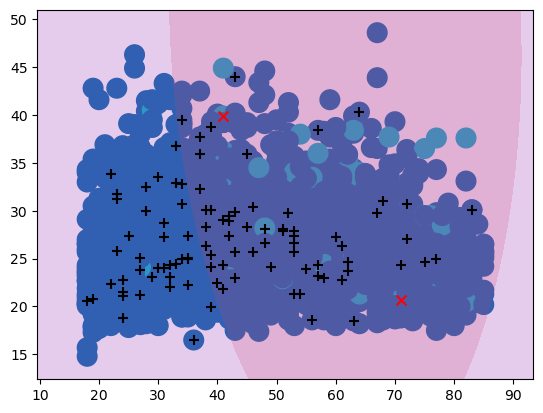

In [ ]:
# AGE (x-axis), BMICALC (y-axis)
plot_svm(X.values, y.values, svm_rbf, features=(0,2))

# Quick Restart

The kernel be crashing!

In [ ]:
import numpy as np
import pandas as pd
import sklearn.model_selection as skm
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from ISLP import confusion_table
from ISLP.svm import plot as plot_svm
df = pd.read_csv("data/nhis_2022.csv")
diabetes = df[(df["REGION"]==4) & (df["ASTATFLG"]==1)]["DIABETICEV AGE SEX BMICALC HRSLEEP MOD10DMIN VIG10DMIN JUICEMNO".split()]
diabetes = diabetes[diabetes["DIABETICEV"].isin([1,2])]
diabetes = diabetes[diabetes["AGE"]<997]
diabetes = diabetes[diabetes["SEX"]<7]
diabetes = diabetes[(diabetes["BMICALC"]>0) & (diabetes["BMICALC"]<996)]
diabetes = diabetes[diabetes["HRSLEEP"]<97]
diabetes = diabetes[(diabetes["MOD10DMIN"]>0) & (diabetes["MOD10DMIN"]<996)]
diabetes = diabetes[(diabetes["VIG10DMIN"]>0) & (diabetes["VIG10DMIN"]<996)]
diabetes = diabetes[diabetes["JUICEMNO"]<=95]
X, y = diabetes.drop(columns=["DIABETICEV"]), diabetes["DIABETICEV"]
X_train,X_test,y_train,y_test = skm.train_test_split(
    X,
    y,
    train_size=0.5,
    random_state=5322
)